In [1]:
import pandas as pd
import numpy as np
import math
from sklearn.linear_model import LinearRegression
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import summary_table
from adjustText import adjust_text
import shap
import os
import scipy
from pathlib import Path
from sklearn.metrics import mean_squared_error

/home/veror/Desktop/Tweet2Geo/venv_new_tweets/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cwd = Path.cwd()
parent_dir = cwd.parent.parent

parent_dir

PosixPath('/home/veror/Desktop/Tweet2Geo')

In [3]:
# DATA FOR FIT

# countr info dataset
country_info = pd.read_csv(parent_dir / 'Data' / 'US' / 'US info no wa.csv')

# population vector
country_pop = country_info['pop 2022'].to_numpy()

# GDP vector
country_gdp = country_info['gdp 2022'].to_numpy()


# GDP per capita vector
country_gdp_per_capita = (country_info['gdp 2022'] / country_info['pop 2022']).to_numpy()


# distances matrix
matrix_distance = pd.read_csv(parent_dir / 'Data' / 'US' / '0 gravity model' / 'distances US no wa.csv')
matrix_distance = matrix_distance.drop(index=[0], columns=['lat_lon'])
matrix_distance = matrix_distance.apply(pd.to_numeric)
matrix_distance = matrix_distance.reset_index(drop=True)
matrix_distance.columns = matrix_distance.index

# countries pairs vector
migration_flows = pd.read_csv(parent_dir / 'Data' / 'US' / '0 gravity model' / 'migration matrix US trans no wa.csv')
country_vector = []
for i in range(len(migration_flows)):
    for col in migration_flows.columns[1:]:
        country_vector.append(migration_flows.at[i, 'Unnamed: 0']+'-'+col)

# df for index
df_flux_no_self = pd.read_csv(parent_dir / 'Data' / 'US' / 'matrix_fluxes_0.5_no_self_loops no wa.csv')

### Model: gdp tot, distance, language, inverse migration

In [ ]:
column1 = 'Source gdp'
column2 = 'Target gdp'
column3 = 'Distance'
column4 = 'Language'
column5 = 'Migration'
column6 = 'flux_percentage_05'
column7 = 'ISO 2'

# results dataframe
res_df = pd.DataFrame()

# flows
normalized_flows = pd.read_csv(parent_dir / 'Data' / 'US' / 'fluxes_0.5_norm_day no wa.csv')
normalized_flows = normalized_flows.apply(pd.to_numeric)#.drop(columns=['Unnamed: 0'])

# migration flows
matr_migr = pd.read_csv(parent_dir / 'Data' / 'US' / '0 gravity model' / 'migration matrix US trans no wa.csv').drop(columns=['Unnamed: 0']) # matrix EU migration
matr_migr = matr_migr.fillna(-1)
matr_migr = matr_migr.replace(0, -1)
matr_migr.columns = df_flux_no_self.index
matr_migr.index = df_flux_no_self.index
matr_migr = matr_migr.apply(pd.to_numeric)



# create sub percentage flow vector
real_vector = []

# create vectors for columns
dist_vector = []
migr_vector = []
flow_vector = []
multiple_country_gdp = []
starting_gdp = np.repeat(country_gdp, 48)


# we also consider language to create plot of migration VS residuals but we don't put migration into the model here
lang_vector = []

for i in range(len(normalized_flows)):

    dist_vector += list(matrix_distance.loc[i])
    migr_vector += list(matr_migr.loc[i])
    flow_vector += list(normalized_flows.loc[i])
    multiple_country_gdp += list(country_gdp)


df_plot = pd.DataFrame({column1: starting_gdp, column2: multiple_country_gdp, column3: dist_vector, column5: migr_vector, column6: flow_vector})
sub_plot = df_plot[(df_plot['flux_percentage_05'] > 0) & (df_plot['Distance'] > 0) & (df_plot['Migration'] > 0)].reset_index(drop=True)
# sub_plot for redisuals
sub_plot_res = df_plot[(df_plot['flux_percentage_05'] > 0) & (df_plot['Distance'] > 0) & (df_plot['Migration'] > 0)]

# create df for residuals plot without lang
residual_df = pd.DataFrame()
residual_df['Source gdp'] = sub_plot['Source gdp']
residual_df['Target gdp'] = sub_plot['Target gdp']
residual_df['Distance'] = sub_plot['Distance']
residual_df['Migration'] = sub_plot['Migration']

# create df for residuals plot with lang
residual_df1 = pd.DataFrame()
residual_df1['Source gdp'] = sub_plot_res['Source gdp']
residual_df1['Target gdp'] = sub_plot_res['Target gdp']
residual_df1['Distance'] = sub_plot_res['Distance']
residual_df1['Migration'] = sub_plot_res['Migration']

# model
real_vector = list(sub_plot['flux_percentage_05'])
sub_plot['flux_percentage_05'] = np.log10(sub_plot['flux_percentage_05'])
sub_plot['Source gdp'] = np.log10(sub_plot['Source gdp'])
sub_plot['Target gdp'] = np.log10(sub_plot['Target gdp'])
sub_plot['Distance'] = np.log10(sub_plot['Distance'])
sub_plot['Migration'] = np.log10(sub_plot['Migration'])
y = sub_plot['flux_percentage_05']
print(sub_plot)
X = sub_plot.drop(columns=['flux_percentage_05'])
print(X)
mod = LinearRegression()
mod.fit(X, y)
print('R squared', mod.score(X, y))
print('intercept', mod.intercept_)
print('coefficients', mod.coef_)
res_df = res_df._append({'R squared': mod.score(X, y), 'Intercept': mod.intercept_, 'Coefficient 1 (Source gdp)': mod.coef_[0], 'Coefficient 2 (Target gdp)': mod.coef_[1], 'Coefficient 3 (dist)': mod.coef_[2], 'Coefficient 4 (Migration)': mod.coef_[3], 'Normalization factor': -mod.intercept_, '# points per fit': len(sub_plot)}, ignore_index=True)
extimated_flux_log = mod.predict(X)
residual = y - extimated_flux_log
residual_df['residuals'] = residual
residual_df['y'] = y

# compute AIC
rss = np.sum((y - extimated_flux_log)**2)
n = len(y)
k = X.shape[1]
# mean square error
mse = mean_squared_error(y, extimated_flux_log)
# log likelihood
log_likelihood = -n / 2 * np.log(2 * np.pi * mse) - (1 / (2 * mse)) * np.sum((y - extimated_flux_log) ** 2)
# AIC and BIC calculations
aic_simpler = 2 * k - 2 * log_likelihood
bic_simpler = np.log(n) * k - 2 * log_likelihood
print('AIC', aic_simpler)
print('BIC', bic_simpler)

res_df.to_csv(parent_dir / 'Data analysis' / 'Gravity model' / 'US' / 'fit_g1_g2_d_lang_m_trans_.csv')

      Source gdp  Target gdp  Distance  Migration  flux_percentage_05
0      11.443760   11.661765  3.363068   3.079904           -0.001918
1      11.443760   11.218064  2.755442   3.186391            0.526355
2      11.443760   12.556074  3.479568   3.903741            0.819267
3      11.443760   11.685179  3.260223   3.522314            0.094992
4      11.443760   11.210357  3.047327   1.929419            0.542150
...          ...         ...       ...        ...                 ...
1959   10.676076   11.965243  3.391945   2.123852           -0.001918
1960   10.676076   11.471116  3.401445   2.555094           -0.603978
1961   10.676076   11.677383  3.297630   2.322219           -0.427887
1962   10.676076   12.372168  3.166579   3.344589            0.492932
1963   10.676076   11.604001  3.152280   2.567026           -0.905008

[1964 rows x 5 columns]
      Source gdp  Target gdp  Distance  Migration
0      11.443760   11.661765  3.363068   3.079904
1      11.443760   11.218064  2.755

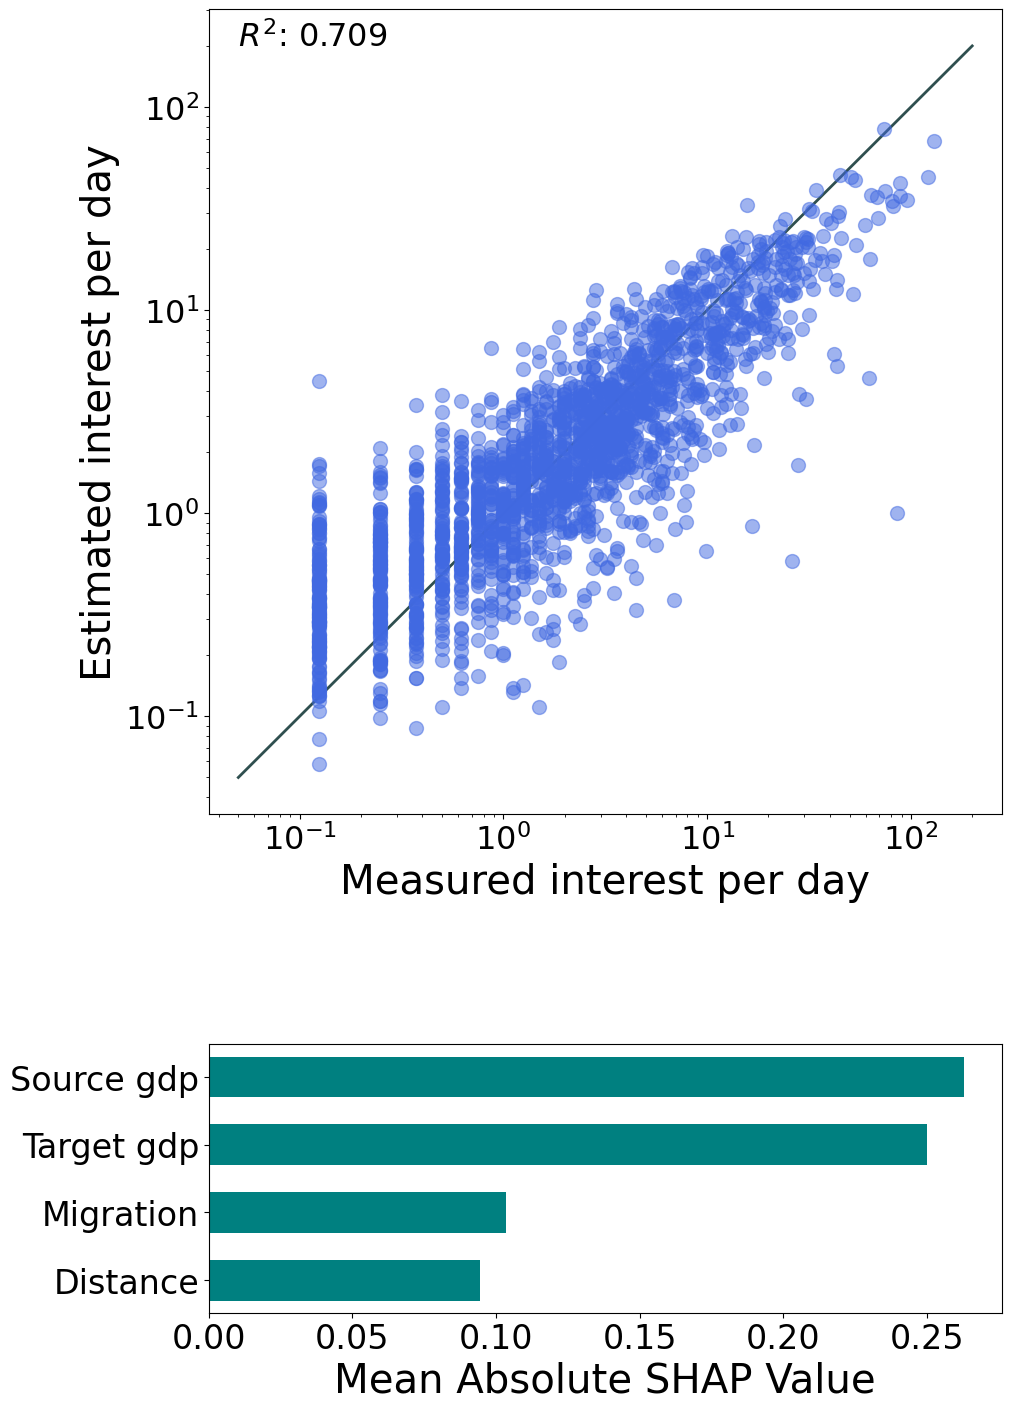

In [ ]:
# params
AREA = 'US'
low_bound = 0.05
high_bound = 200
x = np.linspace(low_bound, high_bound, high_bound)

# shap values
masker = X  
explainer = shap.Explainer(mod, masker)
shap_values = explainer(X)
shap_df = pd.DataFrame(shap_values.values, columns=X.columns)

# Compute mean absolute SHAP value per feature
shap_mean = shap_df.abs().mean().sort_values(ascending=False)

# Create figure
fig = plt.figure(figsize=(10, 14), constrained_layout=True)  

gs = fig.add_gridspec(nrows=18, ncols=1)  #)
ax1 = fig.add_subplot(gs[:12, 0])
ax2 = fig.add_subplot(gs[14:, 0])

# First subplot
ext_vector = 10 ** extimated_flux_log

ax1.plot(x, x, color='darkslategray', alpha=1, linewidth=2.0)
ax1.loglog(real_vector, ext_vector, '.', color='royalblue', alpha=0.5, markersize=20)

ax1.text(low_bound, high_bound, r'$R^{2}$: ' + str(round(mod.score(X, y), 3)), size=23)

ax1.set_xlabel('Measured interest per day', fontsize=29)
ax1.set_ylabel('Estimated interest per day', fontsize=29)
ax1.tick_params(axis='both', labelsize=23)
ax1.set_aspect('equal', adjustable='datalim')

# Second subplot
bar_width = 0.6 
ax2.barh(shap_mean.index[::-1], shap_mean.values[::-1], color='teal', height=bar_width)

ax2.set_xlabel('Mean Absolute SHAP Value', fontsize=29)
ax2.tick_params(axis='both', labelsize=24)

#plt.tight_layout()
file = f'g1_g2_d_lang_m_trans_gravity_model_{AREA}.pdf'
fig.savefig(parent_dir / 'Data analysis' / 'Gravity model' / 'US' / file, transparent=True, dpi = 300)
plt.show()

### Model: population, gdp per capita, distance, language, inverse migration

In [ ]:
column1 = 'Source gdp capita'
column2 = 'Target gdp capita'
column3 = 'Source population'
column4 = 'Target population'
column5 = 'Distance'
column6 = 'Migration'
column7 = 'flux_percentage_05'
column8 = 'ISO 2'

# results dataframe
res_df = pd.DataFrame()

# flows
normalized_flows = pd.read_csv(parent_dir / 'Data' / 'US' / 'fluxes_0.5_norm_day no wa.csv')
normalized_flows = normalized_flows.apply(pd.to_numeric)#.drop(columns=['Unnamed: 0'])

# migration flows
matr_migr = pd.read_csv(parent_dir / 'Data' / 'US' / '0 gravity model' / 'migration matrix US trans no wa.csv').drop(columns=['Unnamed: 0']) # matrix EU migration
matr_migr = matr_migr.fillna(-1)
matr_migr = matr_migr.replace(0, -1)
matr_migr.columns = df_flux_no_self.index
matr_migr.index = df_flux_no_self.index
matr_migr = matr_migr.apply(pd.to_numeric)



# create sub percentage flow vector
real_vector = []

# create vectors for columns
dist_vector = []
migr_vector = []
flow_vector = []
multiple_country_gdp = []
starting_gdp = np.repeat(country_gdp_per_capita, 48)
multiple_country_pop = []
starting_pop = np.repeat(country_pop, 48)


# we also consider language to create plot of migration VS residuals but we don't put migration into the model here
lang_vector = []

for i in range(len(normalized_flows)):

    dist_vector += list(matrix_distance.loc[i])
    migr_vector += list(matr_migr.loc[i])
    flow_vector += list(normalized_flows.loc[i])
    multiple_country_gdp += list(country_gdp_per_capita)
    multiple_country_pop += list(country_pop)


df_plot = pd.DataFrame({column1: starting_gdp, column2: multiple_country_gdp, column3: starting_pop, column4: multiple_country_pop, column5: dist_vector, column6: migr_vector, column7: flow_vector})
sub_plot = df_plot[(df_plot['flux_percentage_05'] > 0) & (df_plot['Distance'] > 0) & (df_plot['Migration'] > 0)].reset_index(drop=True)
# sub_plot for redisuals
sub_plot_res = df_plot[(df_plot['flux_percentage_05'] > 0) & (df_plot['Distance'] > 0) & (df_plot['Migration'] > 0)]

# create df for residuals plot without lang
'''residual_df = pd.DataFrame()
residual_df['Source gdp'] = sub_plot['Source gdp']
residual_df['Target gdp'] = sub_plot['Target gdp']
residual_df['Distance'] = sub_plot['Distance']
residual_df['Migration'] = sub_plot['Migration']'''

# create df for residuals plot with lang
'''residual_df1 = pd.DataFrame()
residual_df1['Source gdp'] = sub_plot_res['Source gdp']
residual_df1['Target gdp'] = sub_plot_res['Target gdp']
residual_df1['Distance'] = sub_plot_res['Distance']
residual_df1['Migration'] = sub_plot_res['Migration']'''

# model
real_vector = list(sub_plot['flux_percentage_05'])
sub_plot['flux_percentage_05'] = np.log10(sub_plot['flux_percentage_05'])
sub_plot['Source gdp capita'] = np.log10(sub_plot['Source gdp capita'])
sub_plot['Target gdp capita'] = np.log10(sub_plot['Target gdp capita'])
sub_plot['Source population'] = np.log10(sub_plot['Source population'])
sub_plot['Target population'] = np.log10(sub_plot['Target population'])
sub_plot['Distance'] = np.log10(sub_plot['Distance'])
sub_plot['Migration'] = np.log10(sub_plot['Migration'])
y = sub_plot['flux_percentage_05']
X = sub_plot.drop(columns=['flux_percentage_05'])
mod = LinearRegression()
mod.fit(X, y)
print('R squared', mod.score(X, y))
print('intercept', mod.intercept_)
print('coefficients', mod.coef_)
res_df = res_df._append({'R squared': mod.score(X, y), 'Intercept': mod.intercept_, 'Coefficient 1 (Source gdp capita)': mod.coef_[0], 'Coefficient 2 (Target gdp capita)': mod.coef_[1], 'Coefficient 3 (Source population)': mod.coef_[2], 'Coefficient 4 (Target population)': mod.coef_[3], 'Coefficient 5 (dist)': mod.coef_[4], 'Coefficient 6 (Migration)': mod.coef_[5], 'Normalization factor': -mod.intercept_, '# points per fit': len(sub_plot)}, ignore_index=True)
extimated_flux_log = mod.predict(X)
residual = y - extimated_flux_log
residual_df['residuals'] = residual
residual_df['y'] = y

# compute AIC
rss = np.sum((y - extimated_flux_log)**2)
n = len(y)
k = X.shape[1]
# mean square error
mse = mean_squared_error(y, extimated_flux_log)
# log likelihood
log_likelihood = -n / 2 * np.log(2 * np.pi * mse) - (1 / (2 * mse)) * np.sum((y - extimated_flux_log) ** 2)
# AIC and BIC calculations
aic_complex = 2 * k - 2 * log_likelihood
bic_complex = np.log(n) * k - 2 * log_likelihood
print('AIC', aic_complex)
print('BIC', bic_complex)

res_df.to_csv(parent_dir / 'Data analysis' / 'Gravity model' / 'US' / 'fit_g1_g2_migr_trans_gdp_pop.csv')

      Source gdp capita  Target gdp capita  Source population  \
0              4.738384           4.794935           6.705376   
1              4.738384           4.734386           6.705376   
2              4.738384           4.964682           6.705376   
3              4.738384           4.918771           6.705376   
4              4.738384           5.383115           6.705376   
...                 ...                ...                ...   
1959           4.911615           4.852236           5.764461   
1960           4.911615           4.748266           5.764461   
1961           4.911615           4.829112           5.764461   
1962           4.911615           4.894619           5.764461   
1963           4.911615           4.833698           5.764461   

      Target population  Distance  Migration  flux_percentage_05  
0              6.866830  3.363068   3.079904           -0.001918  
1              6.483678  2.755442   3.186391            0.526355  
2              7.5

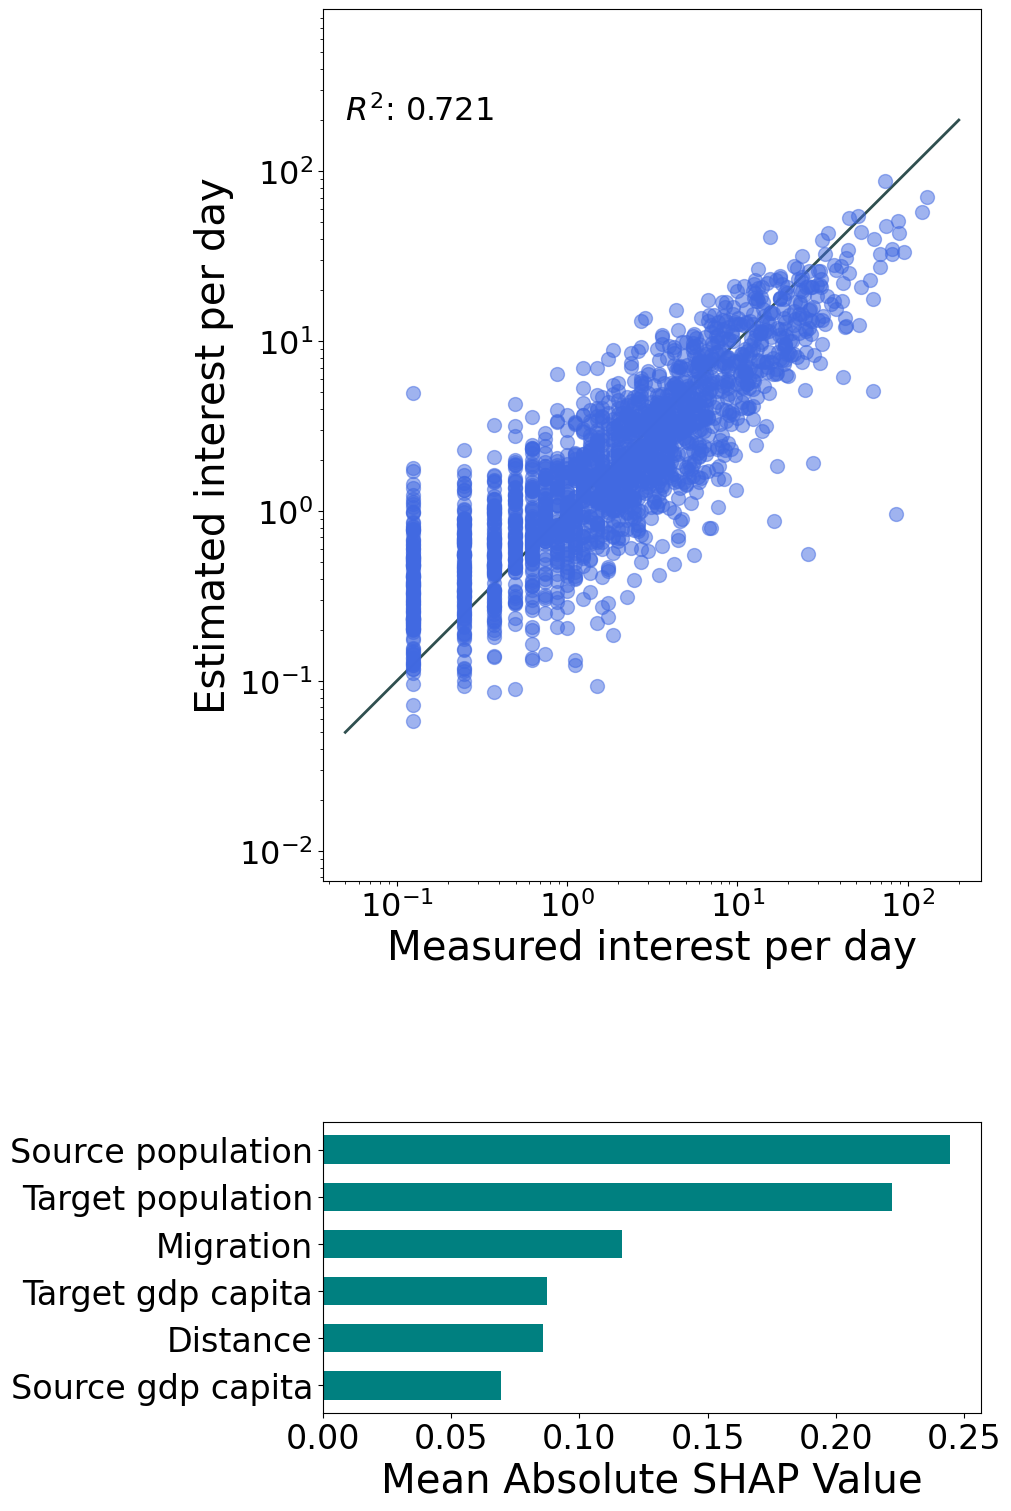

In [ ]:
# params
AREA = 'US'
low_bound = 0.05
high_bound = 200
x = np.linspace(low_bound, high_bound, high_bound)
low_bound_y = 0.03
high_bound_y = 200

# shap values
masker = X  
explainer = shap.Explainer(mod, masker)
shap_values = explainer(X)
shap_df = pd.DataFrame(shap_values.values, columns=X.columns)

# Compute mean absolute SHAP value per feature
shap_mean = shap_df.abs().mean().sort_values(ascending=False)

# Create figure
fig = plt.figure(figsize=(10, 15), constrained_layout=True)  

gs = fig.add_gridspec(nrows=18, ncols=1)  #)
ax1 = fig.add_subplot(gs[:12, 0])
ax2 = fig.add_subplot(gs[14:, 0])

# First subplot
ext_vector = 10 ** extimated_flux_log

ax1.plot(x, x, color='darkslategray', alpha=1, linewidth=2.0)
ax1.loglog(real_vector, ext_vector, '.', color='royalblue', alpha=0.5, markersize=20)

ax1.set_ylim(low_bound_y, high_bound_y)
ax1.text(low_bound, high_bound_y, r'$R^{2}$: ' + str(round(mod.score(X, y), 3)), size=23)

ax1.set_xlabel('Measured interest per day', fontsize=29)
ax1.set_ylabel('Estimated interest per day', fontsize=29)
ax1.tick_params(axis='both', labelsize=23)
ax1.set_aspect('equal', adjustable='datalim')

# Second subplot
bar_width = 0.6 
ax2.barh(shap_mean.index[::-1], shap_mean.values[::-1], color='teal', height=bar_width)

ax2.set_xlabel('Mean Absolute SHAP Value', fontsize=29)
ax2.tick_params(axis='both', labelsize=24)

#plt.tight_layout()
file = f'g1_g2_p1_p2_d_lang_m_trans_gravity_model_{AREA}.pdf'
fig.savefig(parent_dir / 'Data analysis' / 'Gravity model' / 'US' / file, transparent=True, dpi = 300)
plt.show()